# OUTLINE

#### parte 1
. importar dados observados (BNDO)

. tratar os dados e deixar preparado para plotagem

#### parte 2
. importar dados modelados (sECOM)

. tratar e configurar para o mesmo período dos dados observados

. plotar cada série de forma separada

#### parte 3
. plotar as duas séries juntas

. comparar os dados

#### parte 4
. detectar a diferença de fase entre série observada e série modelada

**TODO:: alterar código para pegar série temporal observada por mais tempo (possivelmente mesmo tempo que a rodagem
RUN_ORIGINAL), para poder detectar a diferença de fase entre séries longas.**

In [1]:
# importar funções
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.spatial import cKDTree
import glob
import xray as xr
import os
import string

import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
def skill_willmott(re,m):
    """
    Analise de Skill (Willmott, 1981) em Python
    Esta funcao esta definida como no trabalho de Miranda et al 2012 (BRAZILIAN JOURNAL OF OCEANOGRAPHY, 60(1):11-23, 201)
    CIRCULATION AND SALT INTRUSION IN THE PIACAGUERA CHANNEL, SANTOS (SP)
    Based on the MSE , a quantitative model skill was presented by Willmott (1981)
    The highest value, WS = 1, means perfect agreement between model and observation, while the lowest value,  WS = 0,
    indicates   complete     disagreement. Recently, this was used to evaluate ROMS in the simulation of multiple parameters in the
    Hudson River estuary [ Warner et al., 2005b] and on the southeast New England Shelf [Wilkin ,2006].
    The Willmott skill will be used to  quantify model performance in simulating different parameters from the best model run
    skill parameter (WILLMOTT, 1981)
    Parameters: 
    re - real data
    m - model data
    skill - Skill parameter
    funcao traduzida por: Paula Birocchi
    """
    dif   = re - m 
    soma  = np.nansum(abs(dif)**2) 
    somam = m - np.nanmean(re)  
    c     = re - np.nanmean(re)
    d     = np.nansum((abs(somam) + abs(c))**2)
    skill = 1 - (soma/d)
    return skill

In [3]:
# diretorio base
pwd = os.getcwd() # get current directory
BASE_DIR = pwd.split('/')[:-3]

BASE_DIR = '/'.join((BASE_DIR))
DATA_DIR = BASE_DIR + '/artigo_data/BNDO/'
SIMS_DIR = BASE_DIR + '/artigo_data/simulacoes/'

SIMS_DIR

'/home/tparente/danilo/mestrado/artigo_data/simulacoes/'

# Parte 1

In [4]:
lfiles = glob.glob(DATA_DIR+'1997/*')
lfiles.sort()

# ler, inicialmente, os dois primeiros arquivos para ampliar uma série
files = lfiles[:2]
# files

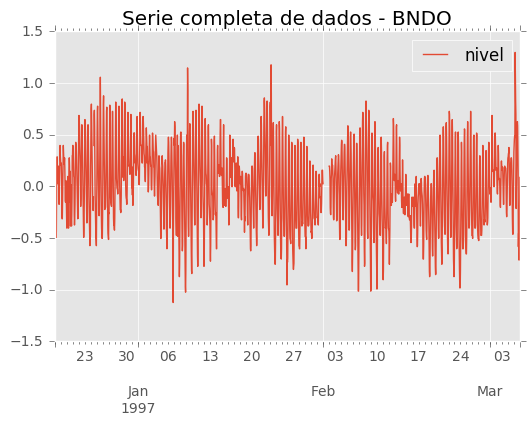

In [5]:
file1 = pd.read_csv(files[0], skiprows=11, delimiter=';', names=['nivel', 'x'])
file1.drop(file1.columns[len(file1.columns)-1], axis=1, inplace=True)

file2 = pd.read_csv(files[1], skiprows=11, delimiter=';', names=['nivel', 'x'])
file2.drop(file2.columns[len(file2.columns)-1], axis=1, inplace=True)

# criar os dataframes
dtRange = pd.date_range(start=file1.index[0], end=file1.index[-1], freq='H')
df1 = pd.DataFrame({'nivel': file1['nivel'].values/100.}, index=dtRange)

dtRange = pd.date_range(start="1997-02-02 00:00", end="1997-03-05 23:00", freq='H')
df2 = pd.DataFrame({'nivel': file2['nivel'].values/100.}, index=dtRange)

dtRange = pd.date_range(start='1997-02-01 00:00', end='1997-02-01 23:00', freq='H')
df3 = pd.DataFrame({'nivel': np.ones(dtRange.shape[0])*np.nan}, index=dtRange)

# concatenar as séries
observ = pd.concat([df1, df3, df2])

# controle de qualidade
cond = observ['nivel'] > 4.
observ[cond] = np.nan

# removendo a média da série temporal
observ['nivel'] = observ['nivel'] - observ['nivel'].mean()

observ.plot(title='Serie completa de dados - BNDO')

#### realizar resample dos dados, para bater com os dados de saída do modelo

In [6]:
# checar os extremos da série para verificar: data e valor
print('Primeiro registro: ')
print(observ.head())
print('-------------------')
print('Último registro: ')
print(observ.tail())

Primeiro registro: 
                        nivel
1996-12-18 00:00:00 -0.004624
1996-12-18 01:00:00  0.095376
1996-12-18 02:00:00  0.085376
1996-12-18 03:00:00 -0.104624
1996-12-18 04:00:00 -0.304624
-------------------
Último registro: 
                        nivel
1997-03-05 19:00:00 -0.704624
1997-03-05 20:00:00 -0.714624
1997-03-05 21:00:00 -0.504624
1997-03-05 22:00:00 -0.184624
1997-03-05 23:00:00  0.085376


In [7]:
# resample para alterar frequência para 6 em 6 horas
obs = observ.resample('3H').mean()
obs.head()

# importante: irei tomar os dados de 6 em 6 horas, mas a partir das 3:00

,nivel
1996-12-18 00:00:00,0.058710
1996-12-18 03:00:00,-0.301290
1996-12-18 06:00:00,-0.074624
1996-12-18 09:00:00,0.132043
1996-12-18 12:00:00,0.162043


In [8]:
# loop para remover os valores em horários que não desejo
hours = [3, 9, 15, 21]

dado = []
time = []
for i in np.arange(len(obs)):
    if obs.index.hour[i] in hours:
        dado.append(obs.nivel[i])
        time.append(obs.index[i])

# converter para dataframe
observ = pd.DataFrame({'nivel':dado},index=time)
observ.tail()

,nivel
1997-03-04 21:00:00,0.165376
1997-03-05 03:00:00,0.942043
1997-03-05 09:00:00,0.175376
1997-03-05 15:00:00,-0.014624
1997-03-05 21:00:00,-0.201290


In [9]:
observ.shape

(312, 1)

# Parte 2

In [10]:
# importar grade do modelo
ncfile = xr.open_dataset(SIMS_DIR+'run06/run06.cdf')

lon = ncfile['lon'].data
lat = ncfile['lat'].data

lon[lon == 0.0] = np.nan
lat[lon == 0.0] = np.nan

# localizacao do terminal da ilha guaiba

ilat = -23.00000000
ilon = -44.01916667

lo = lon.ravel()
la = lat.ravel()

coords = []

for i,j in zip(la,lo):
    coords.append([i,j])

coords = np.array(coords)

locations_name = ['Terminal Ilha Guaiba']
locations_posi = [[ilat,ilon]]

locs = np.asarray(locations_posi)

tree = cKDTree(coords)
# procura em tree os pontos mais próximos dos pontos definidos acima
dists,indexes = tree.query(locs,k=1)

pontos = []

for index in indexes:
    pontos.append(coords[index])

# converter de lista para array
pontos = np.asarray(pontos)

# findind indexes from lat and lon
ind = []

for p in pontos:
    ind.append(np.where(lon == p[1]))

ind = np.asarray(ind)

# vetores para separar i e j para facilitar resgatar os dados de concentração
iss=[]
jss=[]

for i,j in ind:
    iss.append(int(i))
    jss.append(int(j))
    
iss,jss

([193], [26])

In [11]:
dtRange = pd.date_range(start='1996-12-21 03:00',end='1997-01-31 21:00', freq='6H')
len(dtRange)

168

In [19]:
# importar dados do modelo
# elev = ncfile['elev'].data[68:247,iss,jss]
elev = ncfile['elev'].data[:,iss,jss]
elev = np.squeeze(elev)

print(elev.shape)

# time = ncfile['time'][68:247] # 1997-01-31 23:00:00
time = ncfile['time'].values
print(time[-1])

# criar dataframe
model = pd.DataFrame({'modeled':elev}, index=time)

model.tail()

(240,)
1997-02-09T21:26:59.913600000


,modeled
1997-02-09 01:02:59.740800,-0.268274
1997-02-09 06:09:00.172800,0.245689
1997-02-09 11:15:00.000000,-0.178544
1997-02-09 16:20:59.827200,0.016786
1997-02-09 21:26:59.913600,0.118724


In [20]:
time.shape

(240,)

In [25]:
observ[:time[-1]].values

array([[-0.30129038],
       [ 0.13204295],
       [-0.07462371],
       [ 0.31204295],
       [-0.12129038],
       [ 0.32870962],
       [ 0.15870962],
       [-0.11795705],
       [ 0.02870962],
       [ 0.19870962],
       [-0.18462371],
       [ 0.16204295],
       [ 0.12870962],
       [ 0.08870962],
       [ 0.18870962],
       [-0.09462371],
       [ 0.42537629],
       [ 0.12537629],
       [ 0.18537629],
       [-0.21462371],
       [ 0.38870962],
       [-0.17795705],
       [ 0.17537629],
       [-0.52129038],
       [ 0.58870962],
       [-0.15462371],
       [ 0.51870962],
       [-0.52462371],
       [ 0.67204295],
       [-0.24462371],
       [ 0.64870962],
       [-0.48462371],
       [ 0.77870962],
       [-0.19462371],
       [ 0.67204295],
       [-0.43795705],
       [ 0.50204295],
       [-0.17129038],
       [ 0.64870962],
       [-0.38795705],
       [ 0.61870962],
       [-0.00462371],
       [ 0.43204295],
       [-0.11795705],
       [ 0.21870962],
       [ 0

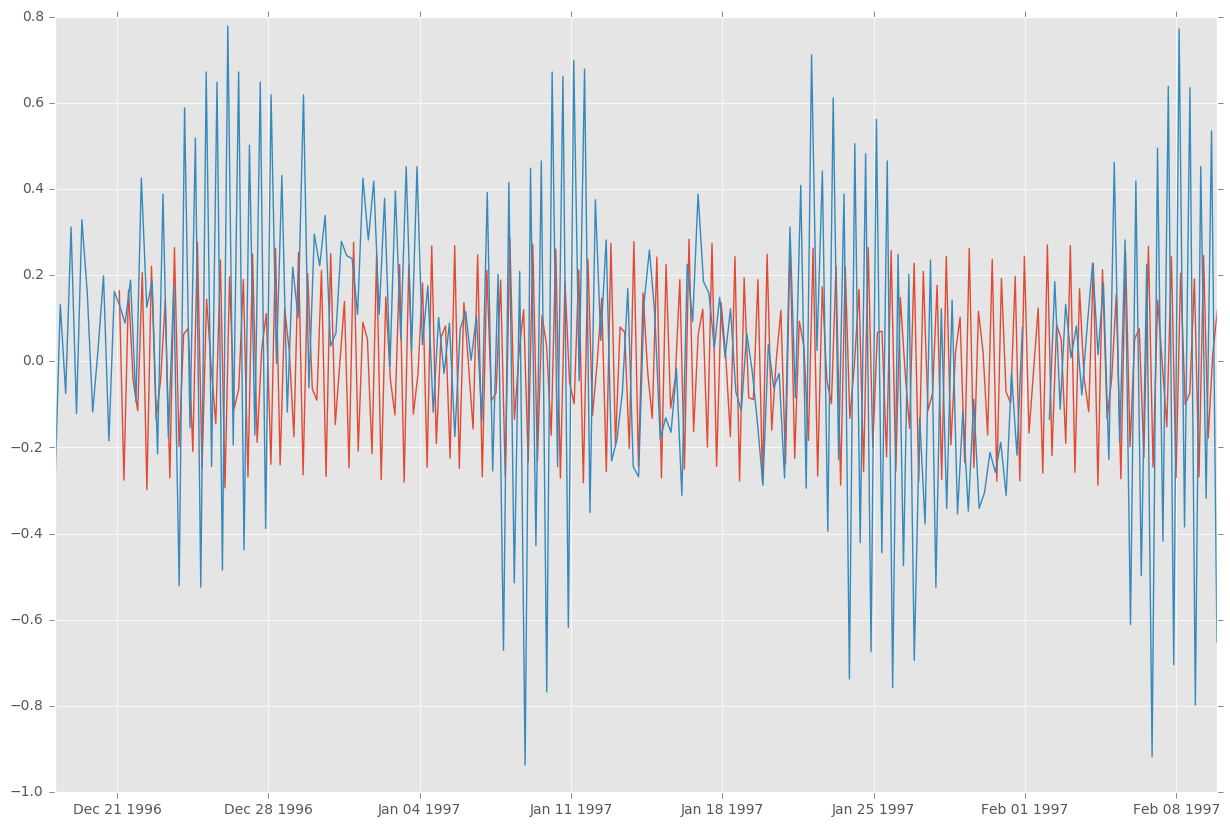

In [26]:
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(model['modeled'])
ax.plot(observ[:time[-1]])

# Parte 3 - Juntando tudo

In [27]:
observ['1997-01-01 03:00':'1997-01-31 21:00'].shape

(124, 1)

In [28]:
print(observ[:len(observ)-1].shape)

time = model.index
print(time[-1])

# observ[model.index[0]:model.index[-1]].shape
print(model['1996-12-18 03:00':].shape)

# df = pd.DataFrame({
#     'sECOM': model.modeled['1996-12-18 03:00':observ.index[-1]].values,
#     'BNDO' : observ.nivel['1996-12-18 03:00':].values,
# }, index=observ.index)

df = pd.DataFrame({
    'sECOM': model.modeled.values,
    'BNDO' : observ.nivel['1996-12-21 03:00':dtRange[-5]].values,
}, index=model.index)

df.plot()

(311, 1)
1997-02-09 21:26:59.913600
(240, 1)


ValueError: Shape of passed values is (2, 164), indices imply (2, 240)

In [ ]:
df.corr()

In [ ]:
skill = skill_willmott(df.BNDO['1997-01-04':].values, df.sECOM['1997-01-04':].values)

skill

In [ ]:
ax = df['1997'].plot(title=u'Elevação do nível do mar \n Terminal da Ilha Guaíba (5h, Skill = %0.2f)'%(skill),figsize=(15,10),fontsize=24)
ax.title.set_size(30)

figname = BASE_DIR+'/github/artigoTG/figures/calibracao/elevacao_5h.png'

plt.savefig(figname)
os.system('convert -trim %s %s'%(figname, figname))

## calculando diferença de fase entre as séries

In [ ]:
from scipy import signal, fftpack
import scipy

def max_correlacao(modelo, observado):
    '''
    obtem a diferenca temporal (em horas) da maxima correlação entre
    duas séries temporais.
    modelo: série temporal saída do modelo, em pandas.Series
    observado: série temporal obtida in situ, em pandas.Series
    
    return
        diferença de fase em horas
    '''
    z = signal.fftconvolve(modelo, observado[::-1])
    lags = np.arange(z.size) - (observado.size - 1)
    return ( lags[np.argmax(np.abs(z))] )

lag = max_correlacao(df.sECOM.values, df.BNDO.values) 

lag

# Realizando a alteração nas componentes de maré para o run_data

In [ ]:
lag = 6

# período das componentes de maré aceitas no sECOM
Tcomponentes = [12., 12.42, 12.66, 23.94, 24.06, 25.86]

# BASE_DIR = '/home/tparente/danilo/mestrado/github/artigoTG/'
DATA_DIR = BASE_DIR + '/github/artigoTG/rotinas/tides/'

# leitura do arquivo com dados de maré (do run_data)
f = open(DATA_DIR+'tide_complement.txt')
f = f.read()
f = f.split('\n')
data = f[2:]

# inicializar novo arquivo de texto
out = open(DATA_DIR+'mare_6h','w')
out.write(f[0]+'\n')
out.write(f[1]+'\n')

# loop 
for i in np.arange(0,len(data)-1,3):
    loc = data[i]
    com = data[i+1]
    deg = data[i+2]
    
    nova_fase  = []
    componente = 0
    
    for fase in string.split(deg,sep=' '):
        if len(fase)!=0:
            nfase = (lag/Tcomponentes[componente]) * 360
            nova_fase.append(float(nfase))
            componente += 1
            
    # imprimir em novo arquivo os dados modificados
    out.write(loc+'\n')
    out.write(com+'\n')
    out.write('%10.5f%10.5f%10.5f%10.5f%10.5f%10.5f\n'%(nova_fase[0],nova_fase[1],nova_fase[2],nova_fase[3],nova_fase[4],nova_fase[5]))
    
# fechar arquivo
out.close()

# /media/danilo/Danilo/mestrado/github/artigoTG/rotinas/tides

In [ ]:
dias = 41
nstep = (dias/15.)*3600*24
dti=15
saving_time = 6*60
avge        = (saving_time*60)/dti
jhm         = nstep/avge

avge_print = '#       AVGE: %i'%avge
nstep_print = '#      NSTEP: %i'%nstep
jhm_print = '#      JHM: %i'%jhm

print('#-----------------------#');
print(nstep_print);
print(avge_print);
print(jhm_print);
print('#        DTI: 15s');
print('#-----------------------#');

# _________________________________________
# _________________________________________
# _________________________________________
# _________________________________________
# _________________________________________
# _________________________________________


### anterior original


In [ ]:
secom = np.asarray([
        0.05066382, -0.14191973,  0.14863421, -0.07172287,  0.13184801,
       -0.18373264,  0.12726995, -0.1397833 ,  0.13581566, -0.1556539 ,
        0.1226919 , -0.14924462,  0.12147108, -0.04486495,  0.09308713,
       -0.12818556,  0.02655272,  0.02929956,  0.03052037, -0.06500839,
       -0.08393102,  0.12757516, -0.02624752, -0.00366244, -0.20845414,
        0.22005188, -0.07019686,  0.09522356, -0.30276209,  0.28506028,
       -0.10468488,  0.17976499, -0.39035556,  0.31222341, -0.14405616,
        0.23927972, -0.44803906,  0.30642454, -0.15840073,  0.29696322,
       -0.45170151,  0.27743018, -0.16175797,  0.31466504, -0.41355104,
        0.2215779 , -0.14344575,  0.295132  , -0.33023043,  0.14924462,
       -0.10712651,  0.23287044, -0.21638944,  0.06287197, -0.04791698,
        0.13734167, -0.08637265, -0.02929956,  0.02044865,  0.02136426,
        0.04455974, -0.10804212,  0.06928124, -0.12025027,  0.12360751,
       -0.15046543,  0.1397833 , -0.19777201,  0.17640775, -0.13886769,
        0.16694644, -0.21425301,  0.16603082, -0.07477491,  0.14405616,
       -0.20296047,  0.04517015,  0.02258508,  0.07965817, -0.11689303,
       -0.09369754,  0.14130932,  0.00122081,  0.01495498, -0.24507859,
        0.24935144, -0.09583397,  0.17030368, -0.34335419,  0.33389287,
       -0.16755684,  0.25942316, -0.46818251,  0.36532885, -0.20936975,
        0.33725011, -0.49565084,  0.3448802 , -0.21486342,  0.35678315,
       -0.46390966,  0.27651457, -0.18739508,  0.33511369, -0.36777048,
        0.18556386, -0.13001679,  0.25637113, -0.23897451,  0.08484663,
       -0.05951473,  0.15229666, -0.10193804, -0.01068213,  0.00518846,
        0.03357241,  0.02380589, -0.07324889])

bndo = np.asarray([-0.34568428,  0.08764906, -0.11901761,  0.26764906, -0.16568428,
        0.28431572,  0.11431572, -0.16235094, -0.01568428,  0.15431572,
       -0.22901761,  0.11764906,  0.08431572,  0.04431572,  0.14431572,
       -0.13901761,  0.38098239,  0.08098239,  0.14098239, -0.25901761,
        0.34431572, -0.22235094,  0.13098239, -0.56568428,  0.54431572,
       -0.19901761,  0.47431572, -0.56901761,  0.62764906, -0.28901761,
        0.60431572, -0.52901761,  0.73431572, -0.23901761,  0.62764906,
       -0.48235094,  0.45764906, -0.21568428,  0.60431572, -0.43235094,
        0.57431572, -0.04901761,  0.38764906, -0.16235094,  0.17431572,
        0.05764906,  0.57431572, -0.10568428,  0.25098239,  0.17764906,
        0.29431572, -0.00901761,  0.02098239,  0.23431572,  0.20098239,
        0.19431572,  0.06431572,  0.38098239,  0.23764906,  0.37431572,
        0.06431572,  0.33431572, -0.05568428,  0.35098239,  0.00764906,
        0.40764906, -0.01901761,  0.40764906, -0.00568428,  0.13098239,
       -0.16235094,  0.05764906, -0.07235094,  0.04431572, -0.21901761,
        0.03098239,  0.07098239, -0.04235094,  0.06098239, -0.18235094,
        0.34764906, -0.29901761,  0.15764906, -0.71568428,  0.37098239,
       -0.55901761,  0.16431572, -0.98235094,  0.40431572, -0.47235094,
        0.42098239, -0.81235094,  0.62764906, -0.28901761,  0.61764906,
       -0.66235094,  0.65431572, -0.08901761,  0.63431572, -0.39568428,
        0.33098239,  0.00431572,  0.23764906, -0.27568428, -0.22568428,
       -0.11568428,  0.12431572, -0.28901761, -0.31235094,  0.09098239,
        0.21431572,  0.06431572, -0.22568428, -0.17568428, -0.20901761,
       -0.06235094, -0.35568428,  0.18098239])

In [ ]:

index = np.arange(len(bndo))

new_df = pd.DataFrame({'sECOM': secom, 'BNDO': bndo}, index=index)

new_df.plot(figsize=(15,10),title='Simulacao anterior (mare adiantada em 24h)')
# plt.savefig('/home/tparente/danilo/mestrado/artigo_data/simulacoes/mare_24h.png')

In [ ]:
skill = skill_willmott(new_df.BNDO.values, new_df.sECOM.values)

skill

In [ ]:
new_df.corr()

## Alterando (atrasando/adiantando) a maré do modelo para melhorar skill

In [ ]:
secom = np.asarray([
        0.05066382, -0.14191973,  0.14863421, -0.07172287,  0.13184801,
       -0.18373264,  0.12726995, -0.1397833 ,  0.13581566, -0.1556539 ,
        0.1226919 , -0.14924462,  0.12147108, -0.04486495,  0.09308713,
       -0.12818556,  0.02655272,  0.02929956,  0.03052037, -0.06500839,
       -0.08393102,  0.12757516, -0.02624752, -0.00366244, -0.20845414,
        0.22005188, -0.07019686,  0.09522356, -0.30276209,  0.28506028,
       -0.10468488,  0.17976499, -0.39035556,  0.31222341, -0.14405616,
        0.23927972, -0.44803906,  0.30642454, -0.15840073,  0.29696322,
       -0.45170151,  0.27743018, -0.16175797,  0.31466504, -0.41355104,
        0.2215779 , -0.14344575,  0.295132  , -0.33023043,  0.14924462,
       -0.10712651,  0.23287044, -0.21638944,  0.06287197, -0.04791698,
        0.13734167, -0.08637265, -0.02929956,  0.02044865,  0.02136426,
        0.04455974, -0.10804212,  0.06928124, -0.12025027,  0.12360751,
       -0.15046543,  0.1397833 , -0.19777201,  0.17640775, -0.13886769,
        0.16694644, -0.21425301,  0.16603082, -0.07477491,  0.14405616,
       -0.20296047,  0.04517015,  0.02258508,  0.07965817, -0.11689303,
       -0.09369754,  0.14130932,  0.00122081,  0.01495498, -0.24507859,
        0.24935144, -0.09583397,  0.17030368, -0.34335419,  0.33389287,
       -0.16755684,  0.25942316, -0.46818251,  0.36532885, -0.20936975,
        0.33725011, -0.49565084,  0.3448802 , -0.21486342,  0.35678315,
       -0.46390966,  0.27651457, -0.18739508,  0.33511369, -0.36777048,
        0.18556386, -0.13001679,  0.25637113, -0.23897451,  0.08484663,
       -0.05951473,  0.15229666, -0.10193804, -0.01068213,  0.00518846,
        0.03357241,  0.02380589, -0.07324889,
        np.nan, np.nan, np.nan, np.nan, np.nan])

bndo = np.asarray([
        np.nan, np.nan, np.nan, np.nan, np.nan,
        -0.34568428,  0.08764906, -0.11901761,  0.26764906, -0.16568428,
        0.28431572,  0.11431572, -0.16235094, -0.01568428,  0.15431572,
       -0.22901761,  0.11764906,  0.08431572,  0.04431572,  0.14431572,
       -0.13901761,  0.38098239,  0.08098239,  0.14098239, -0.25901761,
        0.34431572, -0.22235094,  0.13098239, -0.56568428,  0.54431572,
       -0.19901761,  0.47431572, -0.56901761,  0.62764906, -0.28901761,
        0.60431572, -0.52901761,  0.73431572, -0.23901761,  0.62764906,
       -0.48235094,  0.45764906, -0.21568428,  0.60431572, -0.43235094,
        0.57431572, -0.04901761,  0.38764906, -0.16235094,  0.17431572,
        0.05764906,  0.57431572, -0.10568428,  0.25098239,  0.17764906,
        0.29431572, -0.00901761,  0.02098239,  0.23431572,  0.20098239,
        0.19431572,  0.06431572,  0.38098239,  0.23764906,  0.37431572,
        0.06431572,  0.33431572, -0.05568428,  0.35098239,  0.00764906,
        0.40764906, -0.01901761,  0.40764906, -0.00568428,  0.13098239,
       -0.16235094,  0.05764906, -0.07235094,  0.04431572, -0.21901761,
        0.03098239,  0.07098239, -0.04235094,  0.06098239, -0.18235094,
        0.34764906, -0.29901761,  0.15764906, -0.71568428,  0.37098239,
       -0.55901761,  0.16431572, -0.98235094,  0.40431572, -0.47235094,
        0.42098239, -0.81235094,  0.62764906, -0.28901761,  0.61764906,
       -0.66235094,  0.65431572, -0.08901761,  0.63431572, -0.39568428,
        0.33098239,  0.00431572,  0.23764906, -0.27568428, -0.22568428,
       -0.11568428,  0.12431572, -0.28901761, -0.31235094,  0.09098239,
        0.21431572,  0.06431572, -0.22568428, -0.17568428, -0.20901761,
       -0.06235094, -0.35568428,  0.18098239])

index = np.arange(len(bndo))

df_manual = pd.DataFrame({'sECOM': secom, 'BNDO': bndo}, index=index)

df_manual.plot(figsize=(15,10))
# plt.savefig('/home/tparente/danilo/mestrado/artigo_data/simulacoes/mare_30h_ajustemanual.png')

In [ ]:
max_correlacao(df_manual.sECOM.values, df_manual.BNDO.values) 

In [ ]:
df_manual.corr()

In [ ]:
m = df_manual.BNDO[:52].values
o = df_manual.sECOM[:52].values

skill = skill_willmott(df_manual.BNDO.values,df_manual.sECOM.values)

skill

# -----------------------------------------------------------------------------

In [ ]:
# entendendo melhor como ajustar séries de elevação do nível do mar pela alteração da fase das componentes de maré

a = 1
b = 2

T1 = 2
T2 = 3

omega1 = (2*np.pi)/T1
omega2 = (2*np.pi)/T2

tempo = np.arange(0,30,0.1)

# diferenca de fase muito pequena
phi1 = (np.pi)/4
phi2 = (np.pi)/2

# funcoes de elevacao: phi1/T1 * 2 * np.pi => ajuste que deve ser
f1 = a*np.sin(omega1*tempo + (phi1/T1)*2*np.pi) + b*np.sin(omega2*tempo + (phi1/T2)*2*np.pi) 
f2 = a*np.sin(omega1*tempo + (phi2/T1)*2*np.pi) + b*np.sin(omega2*tempo + (phi2/T2)*2*np.pi) 

plt.plot(tempo,f1,'b',tempo,f2,'k')

# -------------------------------------------------------------------------------------------------

# TESTES de Análise Harmônica

In [ ]:
from pytides.tide import Tide

In [ ]:
tide = Tide.decompose(observ['nivel'].values, observ.index.to_datetime())

In [ ]:
observ.head()

In [ ]:
constituent = [c.name for c in tide.model['constituent']]

d = pd.DataFrame(tide.model, index=constituent).drop('constituent', axis=1)

d.sort_values(by='amplitude', ascending=False).head(25)